In [1]:
import os, sys, glob

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.signal as signal

import mne

import tensorpac
import pactools

import nf_tools.preprocessing as nftprep

In [2]:
# Set subject ID
subj_id = 12
condition = 'maintenance'
condition_acr = 'm'

subj_name = f'subj_{subj_id}'
print(os.listdir('../'))
outputs_path = '../outputs'
data_path = '../data'
meg_dir = os.path.join(data_path, f'subj_{subj_id}', 'meg')
mri_dir = os.path.join(data_path, f'subj_{subj_id}', 'mri')
fs_subjs_dir = os.path.join(data_path, 'fs_subjects_dir')

srcs_dir = os.path.join(outputs_path, subj_name, 'source_space')
os.makedirs(srcs_dir, exist_ok=True)
srcs_itc_dir = os.path.join(outputs_path, subj_name, 'source_space_itc', condition)
os.makedirs(srcs_itc_dir, exist_ok=True)

['.DS_Store', 'codes', 'data', 'plots_molly', 'outputs']


In [3]:

def mk_epochs_new(meg,  mod_freq=None, tmin=None, tmax=None, baseline=None, annot_pattern='', new_event_value=100):
    """This function creates epochs based on specified mod_freq and annotation_pattern
    Arguments:
        meg: annotated MNE object, where bad time spans are annotated as BAD_*
        tmin: start time of the epoch in seconds. This parameter should match with baseline.
        baseline: to specify baseline correction. e.g. tmin=0, baseline=(0, 0) applies no baseline correction.
        mod_freq: to specify the modulating frequency of interest. This parameter should match with the annot_pattern
        annot_pattern: The annotation pattern, based on which epochs are created.
        new_event_value: to specify new label for events. The default is 100. Optional argument.
    Returns:
        epoch: Epoch MNE object.
    Example1:
        The following call will create epochs from mod_freq=1 and encoding events, and will apply baseline correction
        between -0.5 and 0. The length of created epochs would be 8/mod_freq + abs(tmin) = 8 + 0.5 = 8.5 seconds or
        8.5 * sfreq = 8.5 * 300 samples
        mk_epochs(meg.copy(), mod_freq=1., tmin=-0.5, baseline=(-0.5, 0), annot_pattern='e/1.0/')
    Example2:
        create epochs from maintenance events with mod_freq=3.5
        mk_epochs(meg.copy(), mod_freq=3.5, tmin=0, baseline=(0, 0), annot_pattern='m/3.5/')
    Notes:
        tmin and annotation patterns should match.
        baseline = (None, 0) sets baseline to MNE defaults.
        baseline = (0, 0), tmin = 0 sets to no baseline.
        baseline = (-0.5, 0), tmin = -0.5
    """
    if not tmax:
        tmax = (8 / mod_freq) - 1 / meg.info['sfreq']
    events = mne.events_from_annotations(meg)
    annot = list(events[1].keys())
    indx_pattern = np.where([annot_pattern in k for k in annot])[0].tolist()
    event_vals_pattern = np.array(list(events[1].values()))[indx_pattern].tolist()
    indx_events = np.where(np.isin(events[0][:, 2], event_vals_pattern))[0].tolist()
    events4epoch = events[0][indx_events, :]
    events4epoch[:, 2] = new_event_value
    annot_epoch = mne.annotations_from_events(events4epoch, meg.info['sfreq'])
    meg.set_annotations(annot_epoch)
    epoch = mne.Epochs(meg, events=events4epoch, tmin=tmin, tmax=tmax, baseline=baseline)
    return epoch

In [4]:
# Load after-ICA MEG data and make epochs
meg = mne.io.read_raw_fif(os.path.join(meg_dir, 'after_ica_meg.fif'))


Opening raw data file ../data/subj_12/meg/after_ica_meg.fif...
    Read 5 compensation matrices
    Range : 0 ... 1707175 =      0.000 ...  5690.583 secs
Ready.
Opening raw data file /Users/keyvan.mahjoory/k1_analyses/prj_neuroflex/neuroflex_analysis/codes/../data/subj_12/meg/after_ica_meg-1.fif...
    Read 5 compensation matrices
    Range : 1707176 ... 2008175 =   5690.587 ...  6693.917 secs
Ready.
Current compensation grade : 3


Reading forward solution from /Users/keyvan.mahjoory/k1_analyses/prj_neuroflex/neuroflex_analysis/codes/../data/subj_12/mri/file-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 275 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Processing fm= 1.0 Hz
Used Annotations descriptions: ['e/1.0/e0/t0/f/r0', 'e/1.0/e0/t0/f/r1', 'e/1.0/e0/t0/s/r1', 'e/1.0/e0/tpi/f/r0', 'e/1.0/e0/tpi/f/r1', 'e/1.0/e0/tpi/s/r1', 'e/1.0/epi/t0/f/r0', 'e/1.0/epi/t0/f/r1', 'e/1.0/epi/t0/s/r0', 'e/1.0/epi/t0/s/r1', 'e/1.0/epi/tpi/f/r0', 'e/1.0/epi/tpi/f/r1', 'e/1.0/epi/tpi/s/r1', 'e/1.5/e0/t0/f/r0', 'e/1.5

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_39141/4269797282.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


Not setting metadata
72 matching events found
No baseline correction applied
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 8.2e-08 (2.2e-16 eps * 275 dim * 1.3e+06  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 172800
[done]
Using matplotlib as 2D backend.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 6e-13 (2.2e-16 eps * 275 dim * 9.9  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors


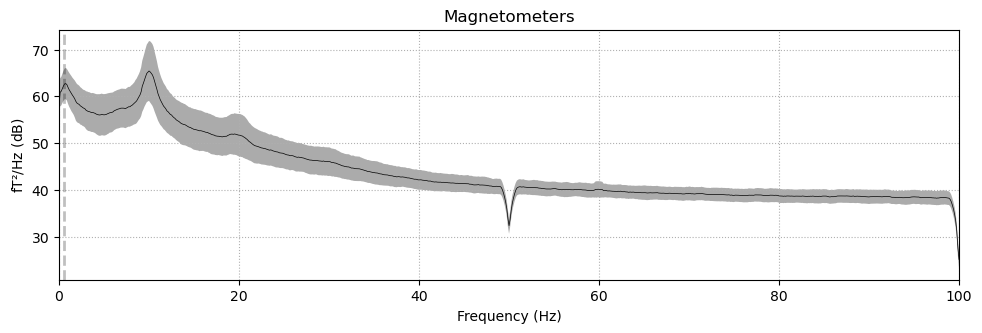

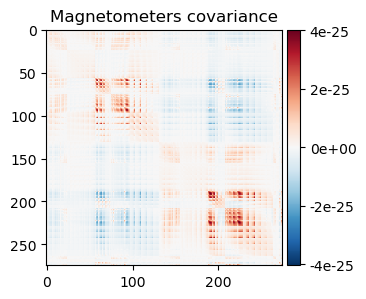

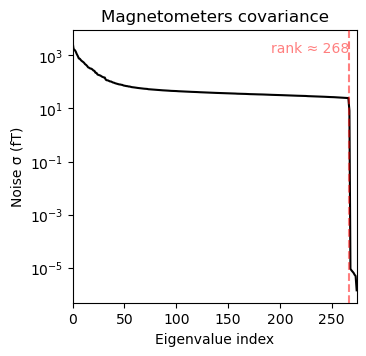

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 7940/8196 = 10.032441
    scale = 9.22947e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 6.4e-13 (2.2e-16 eps * 275 dim * 10  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors
    Setting small MAG ei

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_39141/4269797282.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


Not setting metadata
72 matching events found
No baseline correction applied
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 6.3e-08 (2.2e-16 eps * 275 dim * 1e+06  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 115200
[done]
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 6.8e-13 (2.2e-16 eps * 275 dim * 11  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors


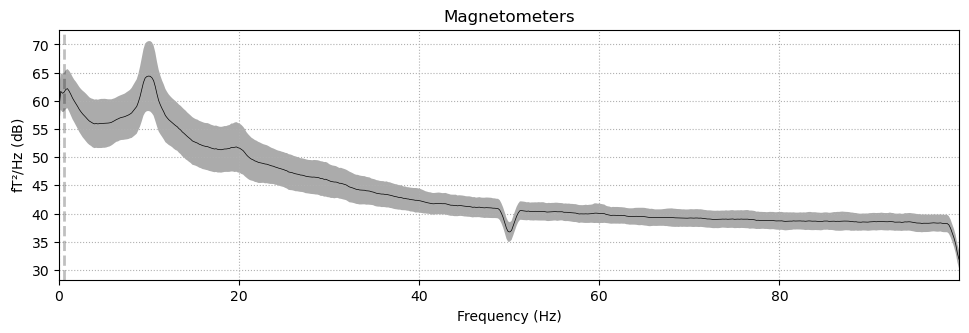

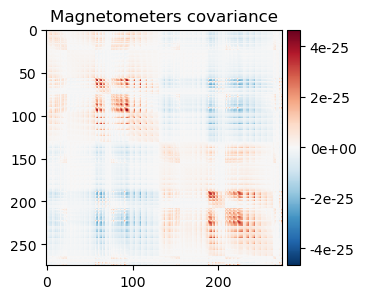

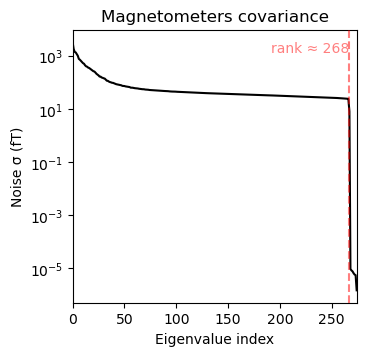

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 7940/8196 = 10.032441
    scale = 9.22947e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 5.7e-13 (2.2e-16 eps * 275 dim * 9.3  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors
    Setting small MAG e

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_39141/4269797282.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


Not setting metadata
72 matching events found
No baseline correction applied
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 6.1e-08 (2.2e-16 eps * 275 dim * 9.9e+05  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 86400
[done]
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 5.9e-13 (2.2e-16 eps * 275 dim * 9.7  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors


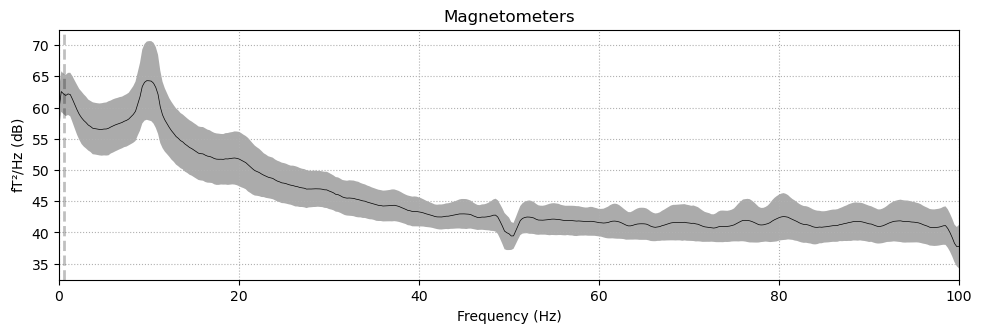

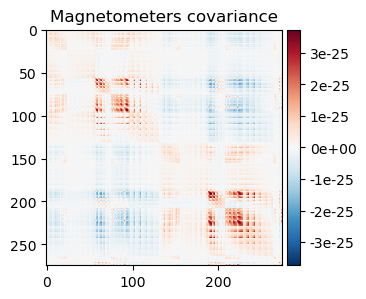

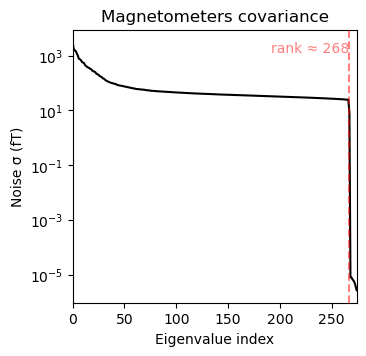

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 7940/8196 = 10.032441
    scale = 9.22947e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 7e-13 (2.2e-16 eps * 275 dim * 11  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors
    Setting small MAG eige

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_39141/4269797282.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


No baseline correction applied
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 5e-08 (2.2e-16 eps * 275 dim * 8.2e+05  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 69120
[done]
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 5.4e-13 (2.2e-16 eps * 275 dim * 8.9  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors


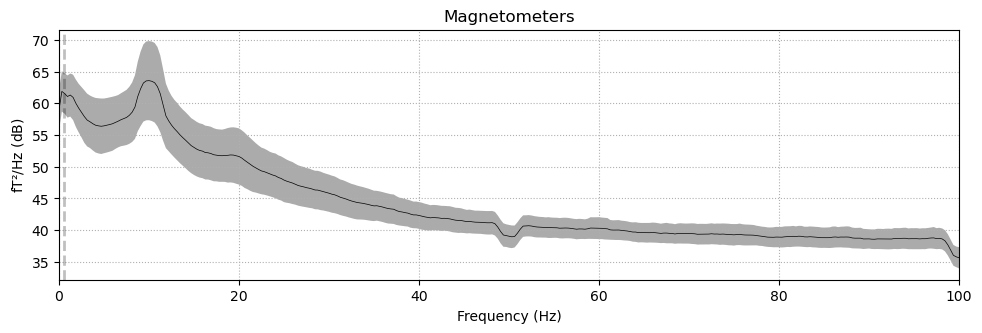

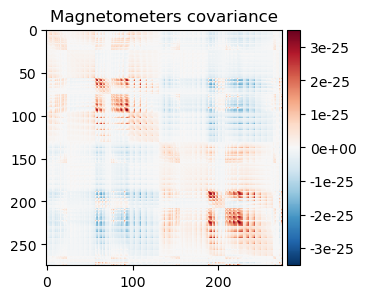

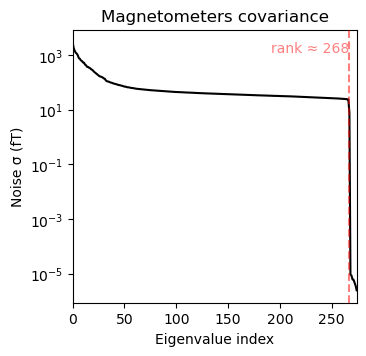

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 7940/8196 = 10.032441
    scale = 9.22947e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 6e-13 (2.2e-16 eps * 275 dim * 9.8  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors
    Setting small MAG eig

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_39141/4269797282.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 4.9e-08 (2.2e-16 eps * 275 dim * 8e+05  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 57600
[done]
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 6.7e-13 (2.2e-16 eps * 275 dim * 11  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors


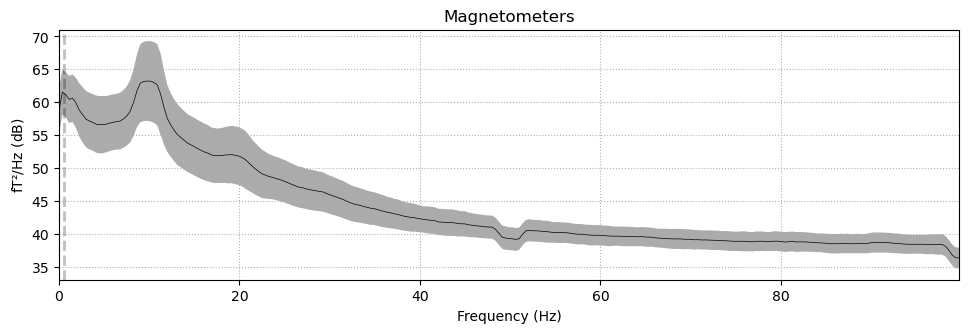

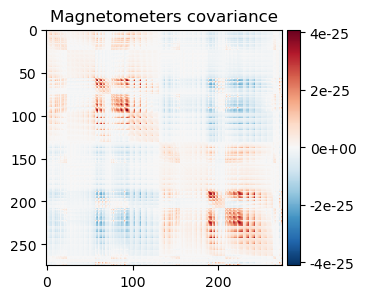

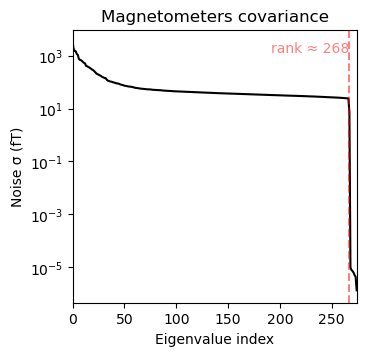

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 7940/8196 = 10.032441
    scale = 9.22947e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 6.7e-13 (2.2e-16 eps * 275 dim * 11  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors
    Setting small MAG ei

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_39141/4269797282.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 4.4e-08 (2.2e-16 eps * 275 dim * 7.2e+05  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 49392
[done]
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 7.8e-13 (2.2e-16 eps * 275 dim * 13  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors


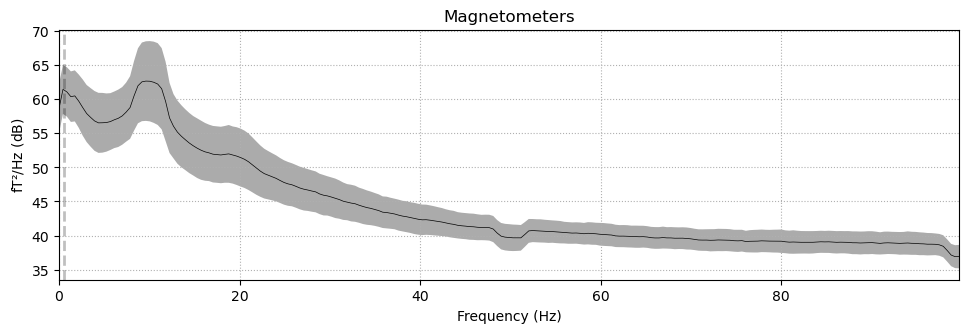

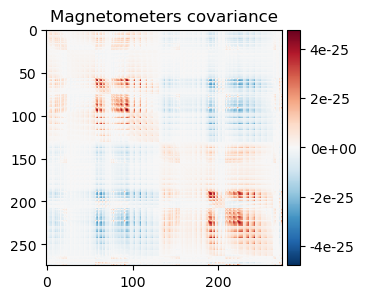

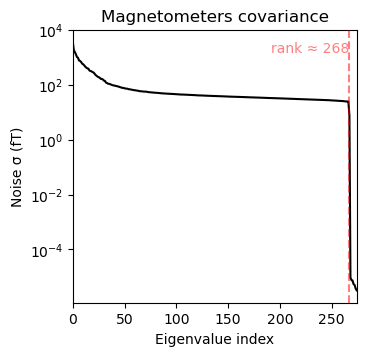

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 7940/8196 = 10.032441
    scale = 9.22947e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 6.3e-13 (2.2e-16 eps * 275 dim * 10  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors
    Setting small MAG ei

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_39141/4269797282.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 4.5e-08 (2.2e-16 eps * 275 dim * 7.4e+05  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 43200
[done]
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 8.1e-13 (2.2e-16 eps * 275 dim * 13  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors


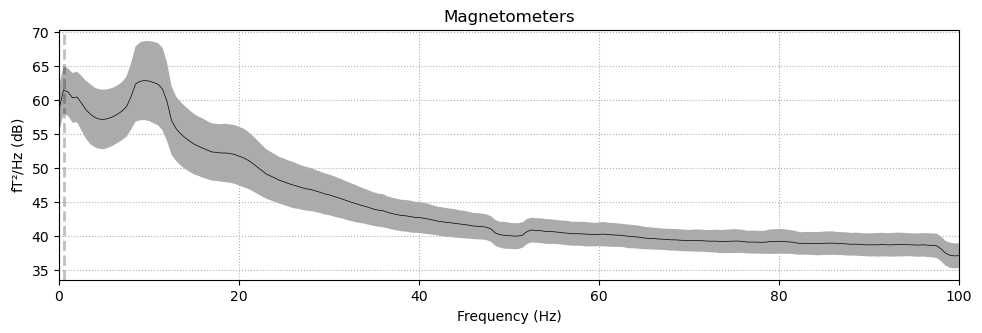

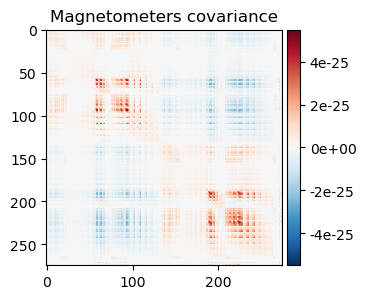

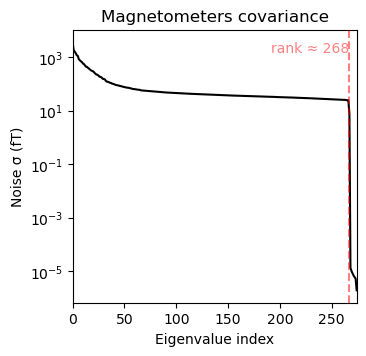

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 7940/8196 = 10.032441
    scale = 9.22947e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 7.7e-13 (2.2e-16 eps * 275 dim * 13  max singular value)
    Estimated rank (mag): 268
    MAG: rank 268 computed from 275 data channels with 0 projectors
    Setting small MAG ei

In [5]:
itpc, xfreq, epow, tpow, F = [], [], [], [], []

# Load forward model
fwd = mne.read_forward_solution(os.path.join(mri_dir, 'file-fwd.fif'))

for j, fm in enumerate(['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0']):

    print("======================================")
    print(f'Processing fm= {fm} Hz')
    print("======================================")

    # Estimate noine covariance matrices from all trials, tmin=-.2 tmax=-0.05 
    _epoch = mk_epochs_new(meg.copy(), mod_freq=float(fm), tmin=-0.2, baseline=None, 
                    annot_pattern=f'{condition_acr}/{fm}', new_event_value=101)
    noise_cov = mne.compute_covariance(_epoch, tmin=-0.2, tmax=-0.05,
                                    method='empirical')

    # Obtain separate Epochs for phase 0 and pi
    epoch0 = mk_epochs_new(meg.copy(), mod_freq=float(fm), tmin=0, baseline=None, 
                    annot_pattern=f'{condition_acr}/{fm}/e0/', new_event_value=101)
    epochpi = mk_epochs_new(meg.copy(), mod_freq=float(fm), tmin=0, baseline=None, 
                    annot_pattern=f'{condition_acr}/{fm}/epi/', new_event_value=101)
    print(epoch0.get_data().shape, epoch0.info['sfreq'])
    print(epochpi.get_data().shape, epochpi.info['sfreq'])

    # Shift phase of pi trials by pi
    sig_shifted = nftprep.shift_phase(epochpi.copy().get_data(), dphi=np.pi, f=float(fm), fs=meg.info['sfreq'])
    print(sig_shifted.shape)

    # Create new Epochs object for shifted pi trials
    epochpi_shifted = mne.EpochsArray(sig_shifted, epochpi.info, tmin=epochpi.tmin)

    epochpi_shifted.plot_psd(fmin=0, fmax=100, average=True, spatial_colors=False, n_jobs=1, show=False)

    # Concatenate epochs with phase 0 and shifted pi trials
    epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])

    # Estimate data covariance from aligned trials, tmin=0 tmax=8/fm
    data_cov = mne.compute_covariance(epoch, tmin=0.0, tmax=8/float(fm),
                                    method='empirical')

    # Visualize noise and data covariance matrices
    with mne.viz.use_browser_backend('matplotlib'):
        mne.viz.plot_cov(noise_cov, meg.info)

    # Source Reconstruction: MNE
    inv_operator = mne.minimum_norm.make_inverse_operator(epoch.info, fwd, data_cov,
                                                        loose=0.2, depth=0.8, verbose=True)
    method = "dSPM"
    snr = 3.
    lambda2 = 1. / snr ** 2
    stc = mne.minimum_norm.apply_inverse_epochs(epoch, inv_operator, lambda2, method=method, 
                            pick_ori='normal', verbose=False)

    # Read Atlas labels for subject
    labels = mne.read_labels_from_annot(subject=subj_name, parc='BN_Atlas', hemi='both', 
                                    surf_name='white', annot_fname=None, regexp=None, 
                                    subjects_dir=fs_subjs_dir, sort=True, verbose=False)
    # Create label to index dictionary
    label2index = {label.name: i for i, label in enumerate(labels)}

    # Time courses for all epochs and all labels (pca across dipoles)
    stc_labels = np.array([k.extract_label_time_course(labels=labels, src=inv_operator['src'], mode='pca_flip', verbose=False) for k in stc])
    stc_labels.shape # (num_epochs, num_labels, num_times)

    _itpc, _xfreq, _epow, _tpow, _F = nftprep.calc_itc(stc_labels, meg.info['sfreq'])
    itpc.append(_itpc)
    xfreq.append(_xfreq)
    epow.append(_epow)
    tpow.append(_tpow)
    F.append(_F)





#plt.savefig(os.path.join(srcs_itc_dir, 'epow_seeds.png'), dpi=300)

In [6]:
itpc[0].shape, itpc[1].shape, itpc[2].shape, itpc[3].shape, itpc[4].shape, itpc[5].shape, itpc[6].shape

((212, 1200),
 (212, 800),
 (212, 600),
 (212, 480),
 (212, 400),
 (212, 343),
 (212, 300))

In [7]:

stg_l = ['A38m_L-lh', 'A41/42_L-lh', 'TE1.0/TE1.2_L-lh', 'A22c_L-lh',  'A22r_L-lh']    #'A38l_L-lh',
stg_r = ['A38m_R-rh', 'A41/42_R-rh', 'TE1.0/TE1.2_R-rh', 'A22c_R-rh', 'A22r_R-rh'] # , 'A38l_R-rh'

fig, ax = plt.subplots(2, 4, sharex=False, sharey=True, figsize=(14, 6))
fig.suptitle(f'{subj_name}, evoked power, {condition}', fontsize=16)
plt.subplots_adjust(hspace=0.4)
for j, fm in enumerate(['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0']):
    for label_name in stg_r+stg_l:
        ix_roi = label2index[label_name]
        ax[j//4, j%4].plot(xfreq[j], epow[j][ix_roi, :].T)
    
    ax[j//4, j%4].set_title(f'fm= {fm} Hz')
    ax[j//4, j%4].set_xlim(0.5, 4.3)
    ax[j//4, j%4].set_ylim(0, 2000)
    ax[j//4, j%4].set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4])
    #ax[j//4, j%4].set_yticks([])
    ax[j//4, j%4].spines['top'].set_visible(False)
    ax[j//4, j%4].spines['right'].set_visible(False)
    #ax[j//4, j%4].spines['left'].set_visible(False)
    #ax[j//4, j%4].grid(True)
    ax[0, 0].set_ylabel('ePow')
    ax[1, 0].set_ylabel('ePow')
    if j==5:
        fig.legend(stg_r+stg_l, loc='lower right');
    
plt.delaxes(ax[1, 3]) ;
plt.savefig(os.path.join(srcs_itc_dir, f'epow_seeds_{condition}.png'), dpi=300)
plt.savefig(os.path.join(srcs_itc_dir, f'epow_seeds_{condition}.eps'), dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:

stg_l = ['A38m_L-lh', 'A41/42_L-lh', 'TE1.0/TE1.2_L-lh', 'A22c_L-lh',  'A22r_L-lh']    #'A38l_L-lh',
stg_r = ['A38m_R-rh', 'A41/42_R-rh', 'TE1.0/TE1.2_R-rh', 'A22c_R-rh', 'A22r_R-rh'] # , 'A38l_R-rh'

fig, ax = plt.subplots(2, 4, sharex=False, sharey=True, figsize=(14, 6))
fig.suptitle(f'{subj_name}, ITPC,  {condition}', fontsize=16)
plt.subplots_adjust(hspace=0.4)
for j, fm in enumerate(['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0']):
    for label_name in stg_r+stg_l:
        ix_roi = label2index[label_name]
        ax[j//4, j%4].plot(xfreq[j], itpc[j][ix_roi, :].T)
    
    ax[j//4, j%4].set_title(f'fm= {fm} Hz')
    ax[j//4, j%4].set_xlim(0.5, 4.3)
    #ax[j//4, j%4].set_ylim(0, 2000)
    ax[j//4, j%4].set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4])
    #ax[j//4, j%4].set_yticks([])
    ax[j//4, j%4].spines['top'].set_visible(False)
    ax[j//4, j%4].spines['right'].set_visible(False)
    #ax[j//4, j%4].spines['left'].set_visible(False)
    #ax[j//4, j%4].grid(True)
    ax[0, 0].set_ylabel('ITPC')
    ax[1, 0].set_ylabel('ITPC')
    if j==5:
        fig.legend(stg_r+stg_l, loc='lower right');
    
plt.delaxes(ax[1, 3]) ;
plt.savefig(os.path.join(srcs_itc_dir, f'itpc_seeds_{condition}.png'), dpi=300)
plt.savefig(os.path.join(srcs_itc_dir, f'itpc_seeds_{condition}.eps'), dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
srcs_itc_dir_files = os.path.join(srcs_itc_dir, 'files')
os.makedirs(srcs_itc_dir_files, exist_ok=True)

for j, _fm in enumerate(np.arange(1, 4.4, 0.5)):
    np.save(os.path.join(srcs_itc_dir_files, f'itpc_{condition}_{_fm}.npy'), itpc[j], allow_pickle=True)
    np.save(os.path.join(srcs_itc_dir_files, f'xfreq_{condition}_{_fm}.npy'), xfreq[j], allow_pickle=True)
    np.save(os.path.join(srcs_itc_dir_files, f'epow_{condition}_{_fm}.npy'), epow[j], allow_pickle=True)